# Predicting the Internet usage using Time series modelling 



#### Description:
Internet Service providers face congestion problems in their networks due to
increased usage and other factors. In this notebook, we use time series forecasting to predict network congestion so that the companies can be better equipped to handle the network traffic.

<font color='red'>Note:</font> The Network is considered to be congested when the value exceeds and breaches the threshold level of 16.40 Gbps </font>
 

The assignment has been divided in following three sections:

<font color='red'>Section 1: Data Preprocessing </font> We have a look at the data and see if it has some missing values, fill the missing values. Furthermore, we will also standardize the data by indexing the dataframe with appropriate timestamp columns.

<font color='red'>Section 2:Data Analysis and Visualization</font> This section involves analysis of the historial data of 61 days in order to understand how the trends and seasonalities in the data. This analysis will be crucial for us when we move on to the next section wherein we will be building a forecasting model to forecst the values for next 14 days

<font color='red'>Section 3: Build and evaluate a Prophet model on a hold-out dataset </font> Here we will build a prophet model and evaluate its performance on a hold-out data set to undderstand how good our model is.

<font color='red'>Section 4: Make the Forecast and perform the analysis of the forecast </font> In the final section we will forecast the values for next 14 days and derive some insights from the results that we get.

## Section 1: Data Preprocessing

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
plt.style.use('fivethirtyeight') # For plots
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
warnings.filterwarnings("ignore")

In [2]:
# reading the input data in a data frame
df=pd.read_csv('internet-usage.csv')

In [3]:
df

,timestamp,values
0,04-11-2019 00:00,10.47
1,04-11-2019 01:00,6.99
2,04-11-2019 02:00,4.63
3,04-11-2019 03:00,3.17
4,04-11-2019 04:00,0.41
...,...,...
1459,03-01-2020 19:00,13.51
1460,03-01-2020 20:00,15.07
1461,03-01-2020 21:00,15.56
1462,03-01-2020 22:00,15.90


In [4]:
# ensuring that the date time format of our dataset is interpreted correctly 
df['timestamp'] = pd.to_datetime(df['timestamp'], format="%d-%m-%Y %H:%M")

Finding is there exists null or missing values in the dataset

In [5]:
df.isna().sum()

timestamp     0
values       18
dtype: int64

In [6]:
df[df.isna().any(axis=1)].timestamp

5      2019-11-04 05:00:00
47     2019-11-05 23:00:00
83     2019-11-07 11:00:00
106    2019-11-08 10:00:00
117    2019-11-08 21:00:00
155    2019-11-10 11:00:00
193    2019-11-12 01:00:00
233    2019-11-13 17:00:00
268    2019-11-15 04:00:00
307    2019-11-16 19:00:00
343    2019-11-18 07:00:00
418    2019-11-21 10:00:00
494    2019-11-24 14:00:00
643    2019-11-30 19:00:00
791    2019-12-06 23:00:00
963    2019-12-14 03:00:00
1149   2019-12-21 21:00:00
1362   2019-12-30 18:00:00
Name: timestamp, dtype: datetime64[ns]

In [7]:
for date in df[df.isna().any(axis=1)].timestamp:
    print(date)
    print('next date aarahi abhi')

2019-11-04 05:00:00
next date aarahi abhi
2019-11-05 23:00:00
next date aarahi abhi
2019-11-07 11:00:00
next date aarahi abhi
2019-11-08 10:00:00
next date aarahi abhi
2019-11-08 21:00:00
next date aarahi abhi
2019-11-10 11:00:00
next date aarahi abhi
2019-11-12 01:00:00
next date aarahi abhi
2019-11-13 17:00:00
next date aarahi abhi
2019-11-15 04:00:00
next date aarahi abhi
2019-11-16 19:00:00
next date aarahi abhi
2019-11-18 07:00:00
next date aarahi abhi
2019-11-21 10:00:00
next date aarahi abhi
2019-11-24 14:00:00
next date aarahi abhi
2019-11-30 19:00:00
next date aarahi abhi
2019-12-06 23:00:00
next date aarahi abhi
2019-12-14 03:00:00
next date aarahi abhi
2019-12-21 21:00:00
next date aarahi abhi
2019-12-30 18:00:00
next date aarahi abhi


So, we have 18 missing values in the dataset. Here we have to options: 
    1. To leave the missing values as they are becasuse the model which we will be using i.e. Prophet is capable of handling missing values
    2. fill the missing values with appropriate values
We will be filling in the missing values because, looking at the dataset we can easily make rough estimations of those missing values and moreover, it is never a good idea to feed any model with missing data.

In [8]:
# filling the missing values with the mean vlaues of the same year, same month, same day of the week and same hour 
for date in df[df.isna().any(axis=1)].timestamp:
    df[df.timestamp == date]= df[df.timestamp == date].fillna\
                                                   (df[(df.timestamp.dt.year == date.year) &\
                                                               (df.timestamp.dt.month == date.month) & \
                                                               (df.timestamp.dt.weekday == date.dayofweek) &\
                                                               (df.timestamp.dt.hour == date.hour) \
                                                               ].mean())

In [9]:
# checking if all the missing values have been filled
df.isnull().sum() 

timestamp    0
values       0
dtype: int64

In [10]:
network_traffic=df
network_traffic.head()

,timestamp,values
0,2019-11-04 00:00:00,10.47
1,2019-11-04 01:00:00,6.99
2,2019-11-04 02:00:00,4.63
3,2019-11-04 03:00:00,3.17
4,2019-11-04 04:00:00,0.41


In [11]:
# Identifying the start date and end date of the data we have 
print("Start date of data :", network_traffic['timestamp'].min())
print("End date of data :",  network_traffic['timestamp'].max())

Start date of data : 2019-11-04 00:00:00
End date of data : 2020-01-03 23:00:00


In [12]:
network_traffic= network_traffic.sort_values('timestamp')

#### Indexing with timestamp column 

In [13]:
network_traffic = network_traffic.set_index('timestamp')
network_traffic.index
network_traffic

,values
timestamp,
2019-11-04 00:00:00,10.47
2019-11-04 01:00:00,6.99
2019-11-04 02:00:00,4.63
2019-11-04 03:00:00,3.17
2019-11-04 04:00:00,0.41
...,...
2020-01-03 19:00:00,13.51
2020-01-03 20:00:00,15.07
2020-01-03 21:00:00,15.56


## Section 2:Data Analysis and Visualization  

Some distinguishable patterns appear when we plot the data. We often see that there is some kind of predictable trend within the data because the human behaviour is often predictable so here we try to analyze the data by plotting he data.
We can also visualize our data using a method called time-series decomposition that allows us to decompose our time series into three distinct components: trend, seasonality, and noise.

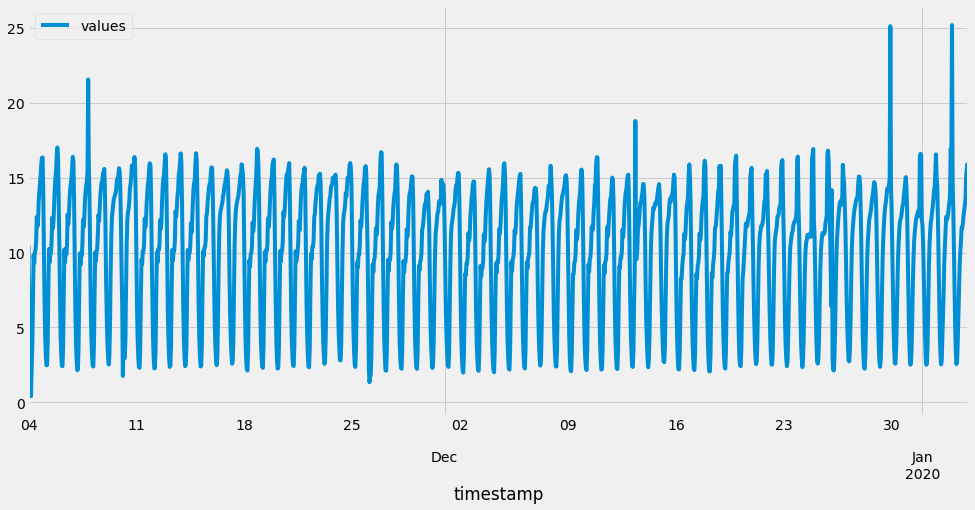

In [14]:
network_traffic.plot(figsize=(15, 7))
plt.show()

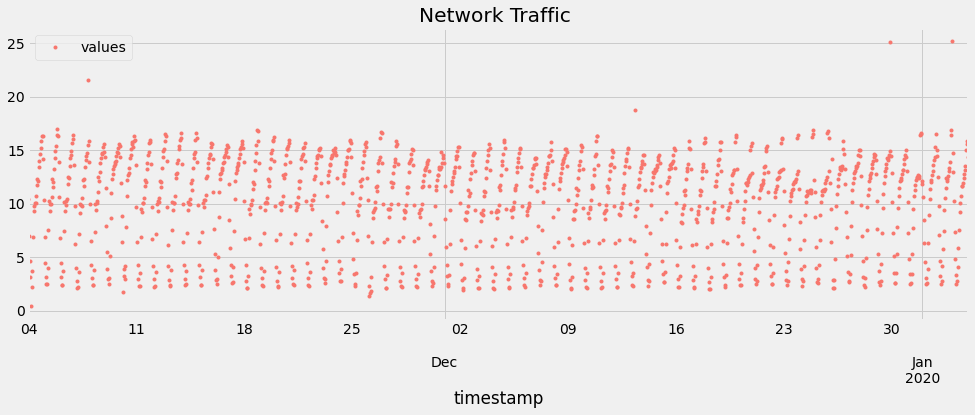

In [15]:
# Color pallete for plotting
color_pal = ["#F8766D", "#D39200", "#93AA00",
             "#00BA38", "#00C19F", "#00B9E3",
             "#619CFF", "#DB72FB"]
network_traffic.plot(style='.', figsize=(15,5), color=color_pal[0], title='Network Traffic ')
plt.show()

<font color='red'>Insights:</font> We can see here that the data is quite uniformaly distributed during the time period provided. There are quite a few outliers present in the later half of the data in the months of December and January but we do not have to worry about them as the Prophet is quite robust and is fully capable of handling the outliers.

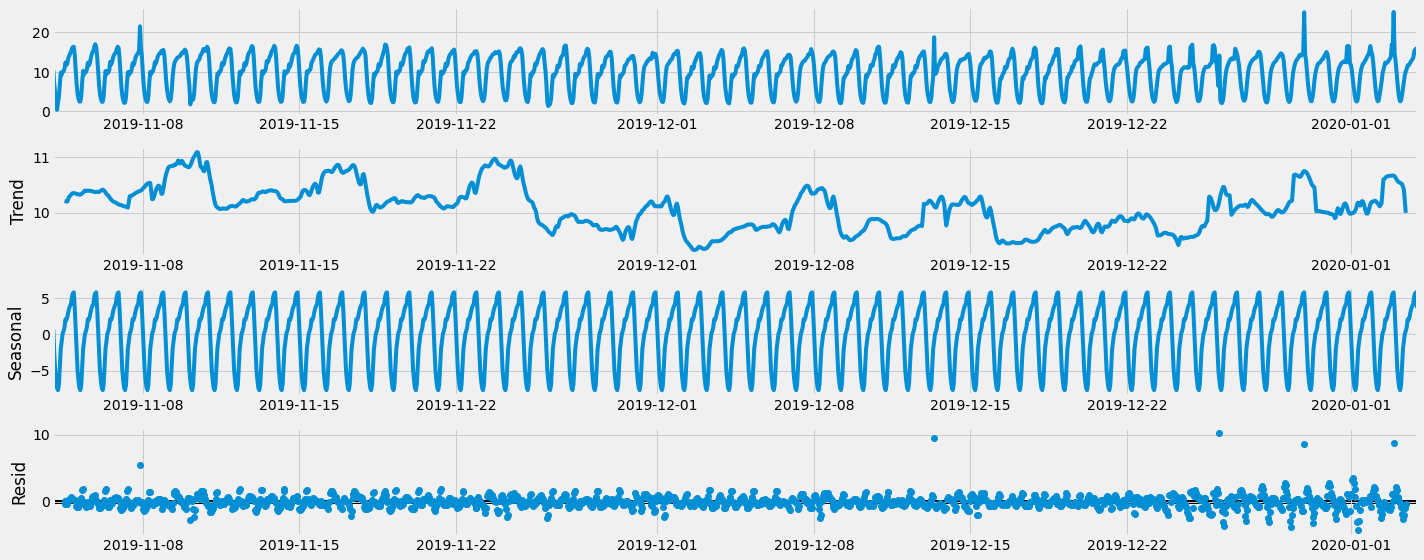

In [16]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 8

decomposition = sm.tsa.seasonal_decompose(network_traffic, model='additive')
fig = decomposition.plot()
plt.show()

<font color='red'>Insights:</font> The seasonal component explains the periodic ups and downs one sees in dataset and this can be thought of as a structured way of thinking about a time series forecasting problem, both generally in terms of modeling complexity and specifically in terms of how to best capture each of these components in the model that we will be building.

The Trend component refers to the pattern in the data that spans across seasonal periods. Here we see that the trend is from high to relatively low to high again. The network usage was high in november then as we enter the december it dropped a bit and stayed comparately how in the initial half of the month and then again started to increase in the final week of december and stayed high during the new yeaar as well.

Seasonal components are the rhythmic forces which operate in a regular and periodic manner over a span of less than a year.Since we are having hourly data we can clearly see that in the seasonal part of the time series. The very short cycles here represent 24 hours period we we do some more analysis later on to see if there exists notable weekly pattern in the data.

Residuals or noise or the random component is what remains behind when you separate out seasonality and trend from the time series. Noise is the effect of factors that you do not know, or which you cannot measure. It is the effect of the known unknowns, or the unknown unknowns. Here we see that the noise stays low during most of the time period but increases as we approach the holiday season. It would be interesting to see what efects the holidays have on forecast.

#### Performing some more visual analysis on the data 

Text(0.5, 1.0, 'Variation of network Traffic during the 24 hours')

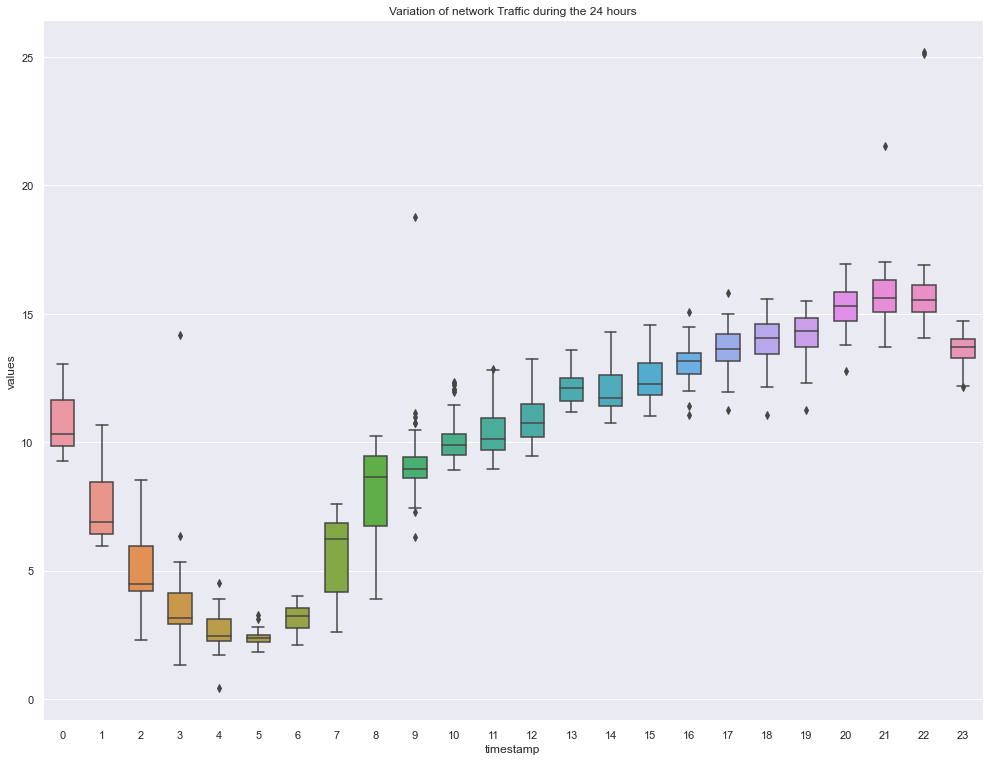

In [17]:
sns.set(rc={'figure.figsize':(15,12)})
sns.boxplot(df['timestamp'].dt.hour, y=df['values'],width=0.6).set_title('Variation of network Traffic during the 24 hours')

<font color='red'>Insights:</font> The above graph shows the box plot of how the network traffic varies during the the 24 hour period through five number summary (“minimum”, first quartile (Q1), median, third quartile (Q3), and “maximum”). The trend in 24 hours is expected and clearly visible. We can see that netowrk traffic starts gradually increasing right from the early hours of the day (6AM) to reach its peak at 9 PM in the evening. The hours of 8, 9,10 PM are the most busy hours during the day. After 10PM as we head late into the night we see sudden drop in the network traffic at 11 PM and this drop continues late into the night and reaches its minimum at 5 AM in the morning. This trend is not surprising and is well expected that people would be on call mostly to speak with their family and freinds during the late evening afte the work. Another point worth noticing here is the interquartile range dipicted by the length of the box. We see that the interquartile range is very less during the busy hours showing that most of the data points lie very close to one another during that time highlighting that the variance is less at that point in time. The length of the box plots are large during early morning hours of 7 and 8 AM showing high variance in data at that point in time. We also see the presence of outliers consistently in the data.


Text(0.5, 1.0, 'Variation of network Traffic during the days of the week')

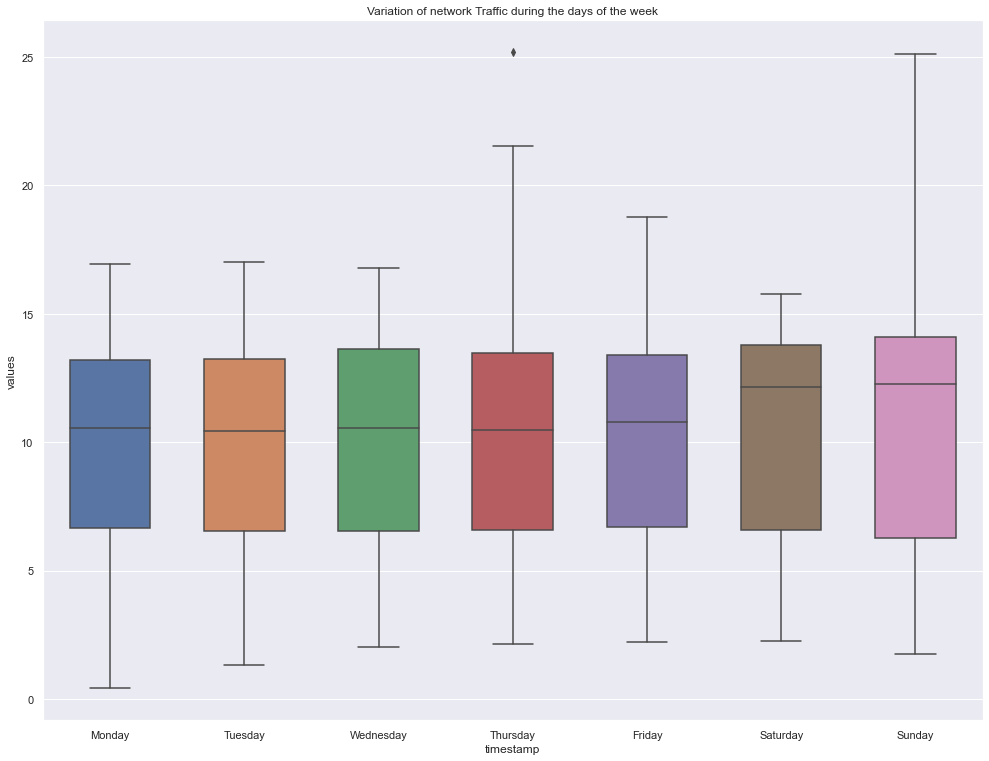

In [18]:
sns.boxplot(df['timestamp'].dt.day_name(), y=df['values'],width=0.6).set_title('Variation of network Traffic during the days of the week')

<font color='red'>Insights:</font> The above graph shows the box plot of how the network traffic varies during the days of the week. We can see that the median of the network traffic (shown by the black line in the box plot) remians constant during the first 4 days of the week ( Monday to Thursday) and as Friday appraoches it rises to reach the maximum values during saturday and sunday. This goes to show that the traffic is expected to be high on weekends when people have holiday. We also see that Thursday has high maximum values and quite a few outliers so there seems to be something that sets thursdays apart from other weekdays.

Now we have done the basic analysis of the daata and are well aware that both daily and weekly seasonality exists in the data. We will know just check if the data is stationary or not to see what models we could apply on it. 

### Checking if the data is stationary  

In [19]:
#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [20]:
adfuller_test(network_traffic['values'])

ADF Test Statistic : -3.1471596071571217
p-value : 0.02325436712538589
#Lags Used : 23
Number of Observations Used : 1440
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


The data is stationary. For Data to be stationary mean that there should be constant mean, variance, and covariance in the data if we divide the data into segments with respect to time. 

This also means that we can apply ARIMA and SARIMA predictive models but for this example we will making use of Prophet. which was developed by Facebook and it works really well with limited data having daily and weekly seasonality.

#### The reasons why we choose Prophet over SARIMA:

For this assignment both SARIMA and Prophet models were built and evaluated to see which models gives better performance and prophet was chosen becase of the following reasons:

1. Prophet offers a robust solution to time series forecast with additional functionality like adding holidays and tuning the seasonality with fourier

2. Less training Time and easy to train: SARIMA model needs more time to train as it has a lot of hyperparameters which need to be explored the autocorrelation and partial autocorrelation plot do provide some good starting point but even after that the hyperameters needed more time and data for exploration to find the best combination.

3. Prophet works very well with relatively small training data. The dataset provided did not include the data for the entire year and prophet model is able to train and capture the trends very well even with limited quantity of the data.


## Section 3:Build and evaluate a Prophet model on a hold-out dataset 

## FB Prophet Time series Forecasting

 We create a test train split to divide our data into training set and test set wherein we would be training the model on the training set and forecast the values for the test time period. Then we will compared the forecasted value with the actual value to see how well our model is able to cature the trends and seasonality in the data.

#### Create train- test set to build and evaluate model 

In [21]:
split_date = '10-dec-2019'
network_traffic_train = network_traffic.loc[network_traffic.index <= split_date].copy()
network_traffic_test = network_traffic.loc[network_traffic.index > split_date].copy()

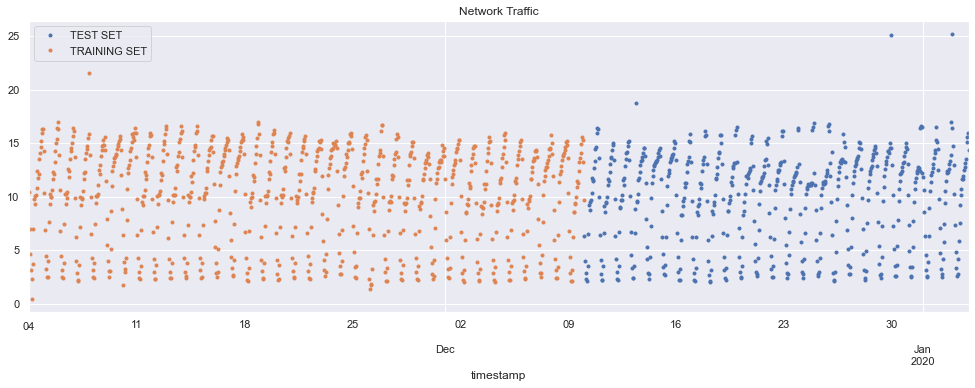

In [22]:
network_traffic_test \
    .rename(columns={'values': 'TEST SET'}) \
    .join(network_traffic_train.rename(columns={'values': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(15,5), title='Network Traffic', style='.')
plt.show()

We can selected 10th December as the date on which we split the data. This gives us enough data to train and test the model on.

In [365]:
print("Training Data size:", network_traffic_train.shape)
print("Testing Data size:", network_traffic_test.shape)

Training Data size: (865, 1)
Testing Data size: (599, 1)


#### Standardize the data in the form suitable for Prophet

Prophet needs data in a simple format with the timestamp column as index and the value as 'y' so here we standardize the data to meet the input requirements of Prophet.

In [366]:
network_traffic_train=network_traffic_train.reset_index() \
    .rename(columns={'timestamp':'ds',
                     'values':'y'})

In [367]:
network_traffic_train.head()

,ds,y
0,2019-11-04 00:00:00,10.47
1,2019-11-04 01:00:00,6.99
2,2019-11-04 02:00:00,4.63
3,2019-11-04 03:00:00,3.17
4,2019-11-04 04:00:00,0.41


#### Decision to include the influence of holidays on the training and forecast

 We have seen in our analysis that during the weekends the network traffic increases and intuitively we expect people to use the network differently on holidays as opposed to on regular days. It might happen that people physically visit theier friends and relatives on holidays so the network usage migh be low during the day and high during the night or it might happen that the network usage might actaully increase as more and more people try to reach out to thier firends and family for greeeting them. Whichever way it might be, we do expect holidays to have some impact on the network usage and hence we have included the Holiday factor into the model.
 
Prophet has in-built holiday calender for some countries that provide a list of public holidays in that country which the prophet takes into consideration while forecasting but unfortunately there is no holiday calender available for Republic of Ireland therefore, I used a opensource library for getting the list of public holidays for Ireland for year 2019 and 2020.

Note: Additional information such as the country for which this data was collected was not provided but looking at the problem statement and companies like eir, vodafone and Three and moreover the region of operation of Sonalake It was assumed that the data belongs to Republic of Ireland. Even if the  assumption is false, the holidays that fall in the given time period such as Chirstmas and New years day are global holidays and and observed aropunf the world so it is safe to consider their impact on the forecast irrespective of the country to which the data belongs.

In [368]:
# import holiday library
# https://pypi.org/project/holidays/
from datetime import date
from workalendar.europe import Ireland

#initialize cal for SG holdays
cal = Ireland()

#input SG holidays for year 2019
year_2019=pd.DataFrame(cal.holidays(2019))
year_2020=pd.DataFrame(cal.holidays(2020))
holidays = pd.concat([year_2019, year_2020])
holidays.columns = ['ds', 'holiday']
holidays

,ds,holiday
0,2019-01-01,New year
1,2019-03-17,Saint Patrick's Day
2,2019-03-18,Saint Patrick substitute
3,2019-04-22,Easter Monday
4,2019-05-06,May Day
5,2019-06-03,June Holiday
6,2019-08-05,August Holiday
7,2019-10-28,October Holiday
8,2019-12-25,Christmas Day
9,2019-12-26,St. Stephen's Day


Defining the hyperparamters for the model

In [392]:
# Setup and train model and fit
model = Prophet(
    interval_width=0.95,
    daily_seasonality=False,
    weekly_seasonality= False,
    yearly_seasonality= False,
    holidays=holidays
    ).add_seasonality(
    name='daily',
    period=1,
    fourier_order=15
    ).add_seasonality(
    name='weekly',
    period=7,
    fourier_order=20,
    prior_scale=18
    )

model.fit(network_traffic_train)

I found that prophet quite often works best when we set yearly_seasonality, weekly_seasonality and daily_seasonality all to false and then add in our own seasonalities like we did over here. By doing this we get more power and control over seasonality. We can define quartely seasonality and can also specify the exact periods of each season which means we can create “new” seasons. We can also add for each seasonality what the prior scale should be instead of them all sharing one scale. 


In the code above we have added daily and weekly seasonality to the model because during the analysis in section 2 we found out that the data has both weekly and daily seasonality. the other component which we have changed is the number of Fourier components (fourier_order) each seasonality is composed of.We can  represent any signal by a sum of sine and cosine waves. This is inherently how Prophet generates its seasonality signals. With the fourier component, we can change how accurately prophet model should start representing the curve or how many more curves can be present in the curve anyhting within the range of 4 to 20 is decent number but the moment it goes higher we need to investigate it.

In [393]:
# Predict on training set with model
traffic_test_fcst = model.predict(df=network_traffic_test.reset_index() \
                                   .rename(columns={'timestamp':'ds'}))

In [394]:
traffic_test_fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,August Holiday,August Holiday_lower,August Holiday_upper,Christmas Day,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-12-10 01:00:00,9.896976,5.123423,6.907303,9.896976,9.896976,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-2.158625,-2.158625,-2.158625,0.0,0.0,0.0,5.949497
1,2019-12-10 02:00:00,9.897885,2.729493,4.469982,9.897885,9.897895,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-3.339871,-3.339871,-3.339871,0.0,0.0,0.0,3.574857
2,2019-12-10 03:00:00,9.898794,1.479170,3.250191,9.898729,9.898955,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-3.990167,-3.990167,-3.990167,0.0,0.0,0.0,2.350392
3,2019-12-10 04:00:00,9.899703,1.097190,2.848979,9.899395,9.900001,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-4.059967,-4.059967,-4.059967,0.0,0.0,0.0,1.974820
4,2019-12-10 05:00:00,9.900612,1.287085,3.085945,9.900091,9.901197,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-3.631505,-3.631505,-3.631505,0.0,0.0,0.0,2.150864
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
594,2020-01-03 19:00:00,10.436815,12.403669,15.937598,8.833910,11.941211,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.035799,2.035799,2.035799,0.0,0.0,0.0,14.253931
595,2020-01-03 20:00:00,10.437724,12.744908,16.414637,8.829355,11.946604,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.016600,2.016600,2.016600,0.0,0.0,0.0,14.614722
596,2020-01-03 21:00:00,10.438633,13.309583,16.817114,8.824801,11.951998,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.966152,1.966152,1.966152,0.0,0.0,0.0,15.172257
597,2020-01-03 22:00:00,10.439542,13.557783,17.081937,8.820246,11.957391,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.836766,1.836766,1.836766,0.0,0.0,0.0,15.327663


traffic_test_fcst dataframe shows the in-sample forecast based on the training of the model. the yhat presents the predicted value. It also gives us yhat_lower and yhat_upper which is specified as the range. These ranges can be considered as uncertainty levels.

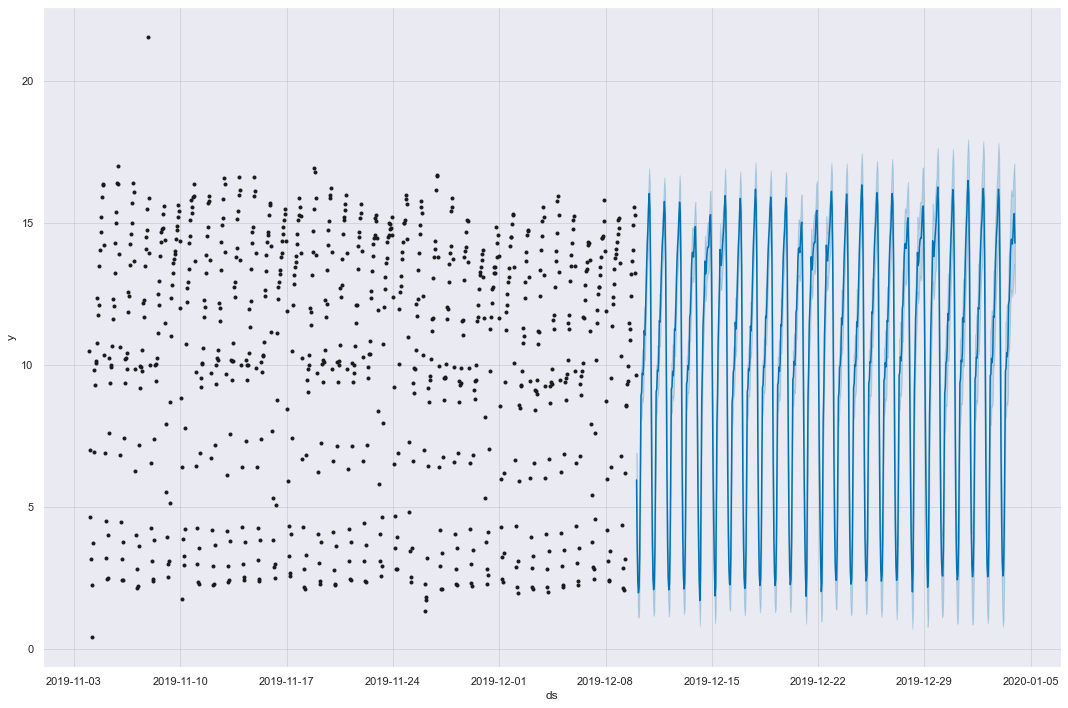

In [395]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(10)
f.set_figwidth(15)
fig = model.plot(traffic_test_fcst,
                 ax=ax)
plt.show()

The figure above shows us the forecast made by the model.

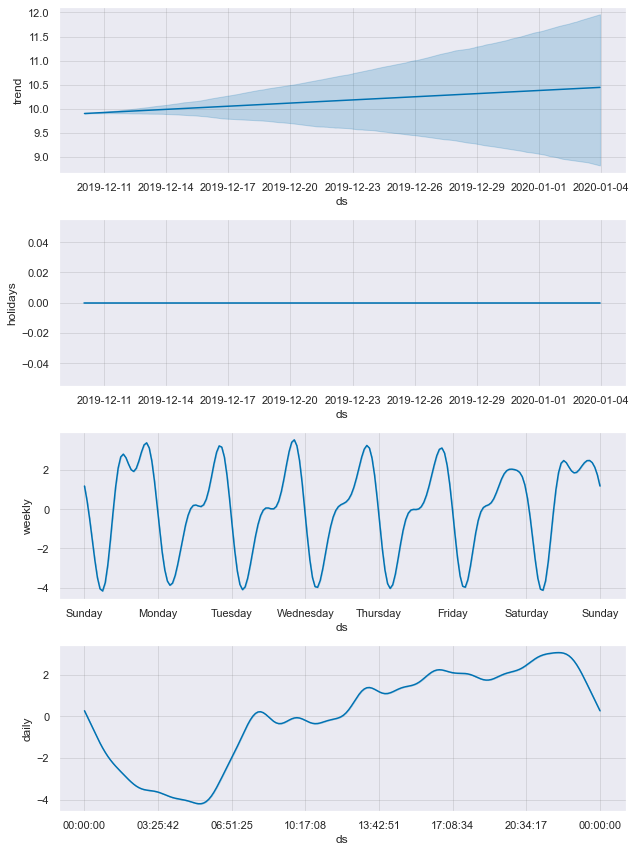

In [396]:
# Plot the components of the model
fig = model.plot_components(traffic_test_fcst)

<font color='red'>Insights:</font> The above graph shows the seasonal decomposition of the forecast, we can see that the general trend is slightly increasing over time. Next we can see that the during the trainig phase of the data, there were no dates that had public holiday so that could be the reason the model shows zero influence of the holidays. 

We also see that the model has picked up weekely and daily seasonality very well. We can even see the same pattern that we saw during the analysis section wherein the network usage decreases from midnight till 6 AM in the morning and is maximum from 8PM to 10PM. 

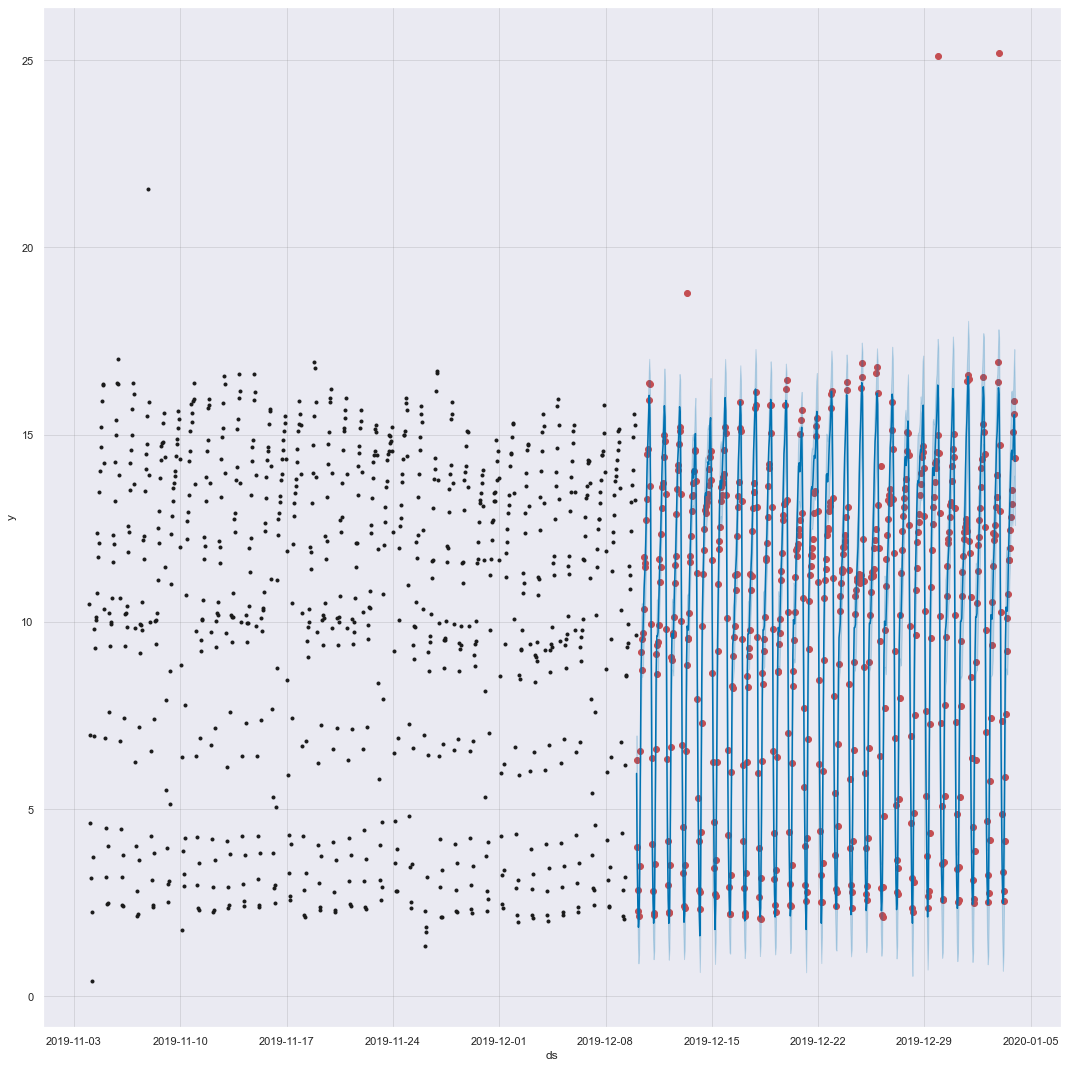

In [388]:
# Plot the forecast with the actuals
f, ax = plt.subplots(1)
f.set_figheight(15)
f.set_figwidth(15)
ax.scatter(network_traffic_test.index, network_traffic_test['values'], color='r')
fig = model.plot(traffic_test_fcst,ax=ax)

<font color='red'>Insights:</font> The above graph shows the forecast of the model on top of the actual data points. This is done to see how good our model actually is and how perfectly it is able to fit the data. This is just a visual confirmation that our model has captutred the variations and the trends very well. Next we will numerically test the performance of the model.

### Calculating the various Errors for the model

In [404]:
mse_prophet=mean_squared_error(y_true=network_traffic_test['values'],
                   y_pred=traffic_test_fcst['yhat'])
print("RMSE for PROPHET {:.2f}".format(np.sqrt(mse_prophet)))

RMSE for PROPHET 1.49


In statistics, the mean squared error (MSE) of an estimator measures the average of the squares of the errors — that is, the average squared difference between the estimated values and what is estimated. The MSE is a measure of the quality of an estimator—it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit.

Root Mean Square Error (RMSE) tells us that our model was able to forecast the average hourly network traffic in the test set within 1.49 units distance of the actual network traffic.For a data where the values range from as low as 2 to all the way upto 25, RMSE of 1.49 is an acceptable error.

In [405]:
mean_absolute_error(y_true=network_traffic_test['values'],
                   y_pred=traffic_test_fcst['yhat'])

0.9307053537252672

Mean Absolute Error: It is the simplest measure of forecast accuracy also known as MAE. MAE is simply, as the name suggests, the mean of the absolute errors. The absolute error is the absolute value of the difference between the forecasted value and the actual value. MAE tells us how big of an error we can expect from the forecast on average. For the current model we can see that the MAE is 0.93 which is very good. 

In [399]:
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=network_traffic_test['values'],
                   y_pred=traffic_test_fcst['yhat'])

12.562170157361951

The Model has a mean absolute percentage error of 12.56% which is again acceptable. This metric is calculated as an average of absolute percentage differences between the actual and the forecasted values.
It emphasizes the percentage (or ratio) difference, not the actual difference, hence it normalizes and would be much less impacted by whether the actual data is big or small.

#### Finally we will perform Cross validation diagnostic 

In [437]:
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
cross_validation_results = cross_validation(model, initial='40days', horizon='15 days', period='12 hour')
print(cross_validation_results)

performance_metrics_results = performance_metrics(cross_validation_results)
print (performance_metrics_results)

INFO:fbprophet:Making 12 forecasts with cutoffs between 2019-12-14 11:00:00 and 2019-12-19 23:00:00



                      ds       yhat  yhat_lower  yhat_upper      y  \
0    2019-12-14 12:00:00  12.497317   11.578380   13.513983  12.47   
1    2019-12-14 13:00:00  13.717983   12.634385   14.756629  13.00   
2    2019-12-14 14:00:00  13.236375   12.240413   14.303113  12.90   
3    2019-12-14 15:00:00  13.338504   12.292354   14.322345  13.10   
4    2019-12-14 16:00:00  13.834529   12.804610   14.890811  13.30   
...                  ...        ...         ...         ...    ...   
4315 2020-01-03 19:00:00  13.389766   12.224588   14.631972  13.51   
4316 2020-01-03 20:00:00  13.835996   12.651165   15.078310  15.07   
4317 2020-01-03 21:00:00  14.324540   13.217232   15.564750  15.56   
4318 2020-01-03 22:00:00  14.500718   13.310432   15.697827  15.90   
4319 2020-01-03 23:00:00  13.389659   12.224801   14.689192  14.37   

                  cutoff  
0    2019-12-14 11:00:00  
1    2019-12-14 11:00:00  
2    2019-12-14 11:00:00  
3    2019-12-14 11:00:00  
4    2019-12-14 11:00:0

In [439]:
performance_metrics_results.mean()

horizon     8 days 06:00:00
mse                 2.53854
rmse                1.49218
mae                 1.07093
mape               0.146863
mdape             0.0888711
coverage           0.624174
dtype: object

The Prophet library makes it possible to divide our historical data into training data and testing data for cross validation. The main concepts for cross validation with Prophet are:

Training data (initial): The amount of data set aside for training. 

Horizon: The data set aside for validation. If you don’t define a period the model will be fitted with Horizon/2.

Cutoff (period): a forecast is made for every observed point between cutoff and cutoff + horizon.

Here we see that even for the cross validation where model is trained on initial 40 days of data and forecasts for next 15 days with a period of 12 hours the mean values of error is relatively small therfore we can go ahead and make the actual forecast 

## Section 4: Make the Forecast and perform the analysis of the forecast

### Make an Out-of-Sample Forecast for next 14 Days

We now include all of the training data so that the forecast can be as accurate as possible for the next 14 days 

In [440]:
model = Prophet(
    interval_width=0.95,daily_seasonality=False,
    weekly_seasonality= False,
    yearly_seasonality= False,
    holidays=holidays
    ).add_seasonality(
    name='daily',
    period=1,
    fourier_order=15
    ).add_seasonality(
    name='weekly',
    period=7,
    fourier_order=20,
    prior_scale=18
    )

model.fit(network_traffic.reset_index() \
              .rename(columns={'timestamp':'ds',
                               'values':'y'}))

In [441]:
network_traffic_forecast_future= model.make_future_dataframe(periods=24*14, freq='H')
# we want hourly forecast for next 14 days hence the period 
network_traffic_forecast_future =model.predict(network_traffic_forecast_future )

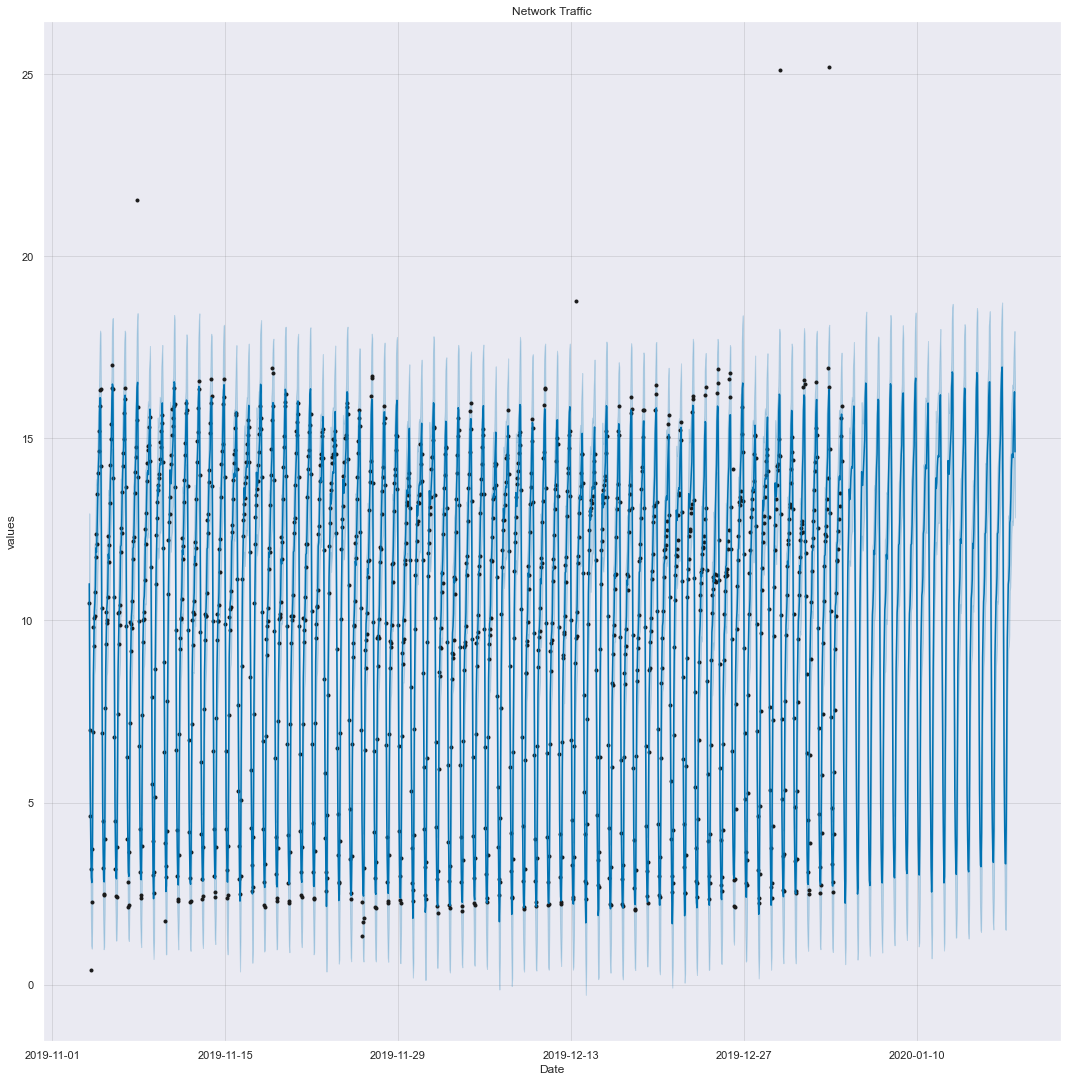

In [447]:
model.plot(network_traffic_forecast_future, xlabel = 'Date', ylabel = 'values',figsize=(15, 15))
plt.title('Network Traffic');

<font color='red'>Insights:</font> Here we see that the model fits the data very well and it is able to capture all of the trends and seasonality and therfore we can be sure that our forecast will be very close to the real values for the 14 day time period

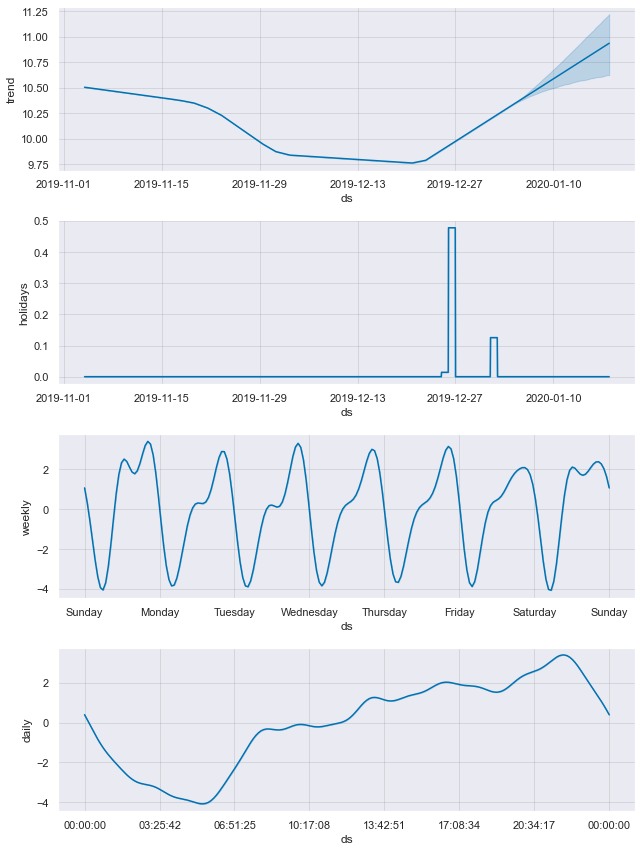

In [451]:
# Plot the components of the model
fig = model.plot_components(network_traffic_forecast_future)

In [452]:
holidays

,ds,holiday
0,2019-01-01,New year
1,2019-03-17,Saint Patrick's Day
2,2019-03-18,Saint Patrick substitute
3,2019-04-22,Easter Monday
4,2019-05-06,May Day
5,2019-06-03,June Holiday
6,2019-08-05,August Holiday
7,2019-10-28,October Holiday
8,2019-12-25,Christmas Day
9,2019-12-26,St. Stephen's Day


<font color='red'>Insights:</font> In the seasonal decomposition we can see that there seems to be an upwards trend started at the change point somewhere arounf 25th December and from that point onwards the network traffic has increased gradually.
Next we also see the holiday influence on date 26th December which was st stephen's day and 1st January which was new year's day. We also the daily seasonality and weekly seasonality being captured by the model which we have already discussed earlier.

In [453]:
network_traffic_forecast_future.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,August Holiday,August Holiday_lower,August Holiday_upper,Christmas Day,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-11-04 00:00:00,10.504780,9.204816,12.939896,10.504780,10.504780,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.109999,0.109999,0.109999,0.0,0.0,0.0,11.007685
1,2019-11-04 01:00:00,10.504393,5.776218,9.340330,10.504393,10.504393,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-1.387743,-1.387743,-1.387743,0.0,0.0,0.0,7.624658
2,2019-11-04 02:00:00,10.504006,3.409824,6.962358,10.504006,10.504006,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-2.663594,-2.663594,-2.663594,0.0,0.0,0.0,5.150210
3,2019-11-04 03:00:00,10.503619,2.016160,5.614346,10.503619,10.503619,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-3.518845,-3.518845,-3.518845,0.0,0.0,0.0,3.833276
4,2019-11-04 04:00:00,10.503231,1.070570,4.807160,10.503231,10.503231,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,-3.862515,-3.862515,-3.862515,0.0,0.0,0.0,2.949722


In [475]:
network_traffic_forecast_future['ds'].max()

Timestamp('2020-01-17 23:00:00')

In [458]:
# checking the forecast duration
network_traffic_forecast_future['ds'].max()-network_traffic.index.max()

Timedelta('14 days 00:00:00')

The network is considered to be congested if the value at any hour reaches the threshold of 16.40 so we will see at waht date and hour the thrreshold is crossed

In [454]:
above_threshold_forecast=network_traffic_forecast_future[network_traffic_forecast_future['yhat']>16.4]

In [459]:
# Seeing the max date of data that was provided to us
network_traffic.index.max()

Timestamp('2020-01-03 23:00:00')

In [461]:
network_congestion= above_threshold_forecast[above_threshold_forecast['ds']>'2020-01-03 23:00:00']

In [462]:
network_congestion

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,August Holiday,August Holiday_lower,August Holiday_upper,Christmas Day,...,holidays,holidays_lower,holidays_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
1509,2020-01-05 21:00:00,10.407216,14.804023,18.347521,10.392746,10.424125,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.311995,3.311995,3.311995,0.0,0.0,0.0,16.516530
1510,2020-01-05 22:00:00,10.409035,14.591095,18.476170,10.394218,10.426618,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.691013,2.691013,2.691013,0.0,0.0,0.0,16.480557
1557,2020-01-07 21:00:00,10.494528,14.814153,18.386723,10.450603,10.545431,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.204139,3.204139,3.204139,0.0,0.0,0.0,16.495986
1558,2020-01-07 22:00:00,10.496347,14.614415,18.283875,10.451718,10.548019,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.562237,2.562237,2.562237,0.0,0.0,0.0,16.439093
1605,2020-01-09 21:00:00,10.581841,14.881678,18.289877,10.494484,10.670971,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.126269,3.126269,3.126269,0.0,0.0,0.0,16.505429
1606,2020-01-09 22:00:00,10.583660,14.907680,18.454391,10.494971,10.673801,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.686609,2.686609,2.686609,0.0,0.0,0.0,16.650777
1677,2020-01-12 21:00:00,10.712809,14.921153,18.590020,10.552988,10.869351,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.311995,3.311995,3.311995,0.0,0.0,0.0,16.822123
1678,2020-01-12 22:00:00,10.714628,14.936060,18.690279,10.553851,10.871947,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.691013,2.691013,2.691013,0.0,0.0,0.0,16.786150
1725,2020-01-14 21:00:00,10.800122,15.020241,18.578159,10.582458,11.007497,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.204139,3.204139,3.204139,0.0,0.0,0.0,16.801579
1726,2020-01-14 22:00:00,10.801941,14.959413,18.474482,10.583249,11.010147,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.562237,2.562237,2.562237,0.0,0.0,0.0,16.744687


In [468]:
print("The network is predicted to to be congested on the following dates")
print (network_congestion.ds.dt.strftime('%y-%m-%d').unique())

The network is predicted to to be congested on the following dates
['20-01-05' '20-01-07' '20-01-09' '20-01-12' '20-01-14' '20-01-15'
 '20-01-16']


In [471]:
network_congestion_analysis=network_congestion[['ds','yhat_lower', 'yhat_upper','yhat']]

In [474]:
network_congestion_analysis['day']=network_congestion_analysis['ds'].dt.day_name()
network_congestion_analysis

,ds,yhat_lower,yhat_upper,yhat,day
1509,2020-01-05 21:00:00,14.804023,18.347521,16.516530,Sunday
1510,2020-01-05 22:00:00,14.591095,18.476170,16.480557,Sunday
1557,2020-01-07 21:00:00,14.814153,18.386723,16.495986,Tuesday
1558,2020-01-07 22:00:00,14.614415,18.283875,16.439093,Tuesday
1605,2020-01-09 21:00:00,14.881678,18.289877,16.505429,Thursday
1606,2020-01-09 22:00:00,14.907680,18.454391,16.650777,Thursday
1677,2020-01-12 21:00:00,14.921153,18.590020,16.822123,Sunday
1678,2020-01-12 22:00:00,14.936060,18.690279,16.786150,Sunday
1725,2020-01-14 21:00:00,15.020241,18.578159,16.801579,Tuesday
1726,2020-01-14 22:00:00,14.959413,18.474482,16.744687,Tuesday


<font color='red'>Insights </font> According to the forecast we can say that the network is expected to be congested during 7 out of next 14 days. our Exploratory analysis showed that the network traffic was high during the weekends and maximum during the hours 8PM to 10PM.We see that trend follwing through even in the forecast. We even noticed higher usuage on Thursday compared to other days. Even detail is dipicted in the prediction here. We can say that based on the training data availble to us we wiil have network congestion during the the hours of 9PM and 10PM on the above mentioned dates. 

In [422]:
# Let's get the sum of yhat (the prediction)
sum_yhat = network_traffic_forecast_future['yhat'].sum()
print('Forecast sum is:', sum_yhat)

sum_components = network_traffic_forecast_future['trend'].sum()+network_traffic_forecast_future['weekly'].sum()+network_traffic_forecast_future['holidays'].sum()
print('Sum of components is:', sum_components)
print('The model is equal to the sum of its components:', sum_yhat.round()==sum_components.round())

Forecast sum is: 18322.500423855323
Sum of components is: 18322.50042384974
The model is equal to the sum of its components: True


<font color='red'>Summary and inference:</font> We had 61 days of time series data and we had to forecast the forecast the values for next 14 days to predict if the network would face congestion duriong any of the days. In order to forecast the values, we fitted prophet model of time series forecasting on the data performed through evaluation. We achieved around 1.49 RMSE value with was good given that we had the data that varied from 2 all the way upto 25 on some days. We found that there is daily seasonality and weekly seasonality present in the data. The network usage is maximum on weekends and during the hours of 8PM to 10PM. We find that after December 25th there was been increase in network usage and based on that the model predicted that during the period of 3rd Jan to 17th Jan the network would be congested on 7 days,ie. on 5th, 7th, 9th, 12th, 14th,15th, 16th of January. This prediction is well in alignment with the analysis that we performed.